In [1]:
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import sys
import matplotlib
import matplotlib.pyplot as plt
from skimage.color import lab2rgb
from sklearn import model_selection
from sklearn.naive_bayes import GaussianNB
import skimage
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from functools import reduce
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
from scipy import stats

C:\Users\Matthew\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def to_timestamp(dateTime):
    return dateTime.timestamp()

#This is actualy useless lol, genre names are never used
#def map_genre(row):
#    result = []
#    for genre_code in row:
#        matches = genres[genres['wikidata_id'] == genre_code]['genre_label'].values
#        for match in matches:
#            result.append(match)
#    return result

In [3]:
wikidata = pd.read_json('movies/data/wikidata-movies.json.gz', orient='record', lines=True, encoding="utf8", convert_dates=['publication_date'])
genres = pd.read_json('movies/data/genres.json.gz', orient='record', lines=True, encoding="utf8")

In [4]:
wikidata = wikidata[wikidata['made_profit'].notnull()].reset_index(drop=True)
wikidata['publication_timestamp'] = wikidata['publication_date'].apply(to_timestamp)

In [6]:
rotten_tomatoes = pd.read_json('movies/data/rotten-tomatoes.json.gz', orient='record', lines=True)
omdb = pd.read_json('movies/data/omdb-data.json.gz', orient='record', lines=True)
combined = wikidata.join(rotten_tomatoes.set_index('rotten_tomatoes_id'), on='rotten_tomatoes_id', rsuffix='_rt')
combined = combined.join(omdb.set_index('imdb_id'), on='imdb_id')

# Is there a difference between the positivity of critics and the audience?

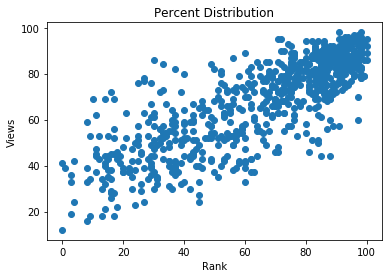

In [7]:
plt.title('Percent Distribution')
plt.xlabel('Rank')
plt.ylabel('Views')
plt.scatter(combined['critic_percent'], combined['audience_percent'])
plt.show()

In [8]:
test3 = combined[combined['audience_percent'].notnull() & combined['critic_percent'].notnull()]
print(stats.normaltest(test3['audience_percent']).pvalue) #<0.05, therefore not normal
print(stats.mannwhitneyu(test3['critic_percent'], test3['audience_percent']).pvalue) #>0.05, therefore one distribution is higher than the other
print(test3['audience_percent'].mean())
print(test3['critic_percent'].mean())
#The audience is slightly more positive than the critics

3.608996083927233e-17
0.4397286644629225
68.09782608695652
65.06657608695652


# Have average ratings changed over time?

In [9]:
critic_average_test = combined[['publication_date','publication_timestamp','critic_average']].dropna()
fit = stats.linregress(critic_average_test['publication_timestamp'], critic_average_test['critic_average'])
critic_average_test['prediction'] = critic_average_test['publication_timestamp']*fit.slope + fit.intercept
print(fit.pvalue) #p < 0.05, therefore we can conclude that critic ratings are decreasing.
print(fit.rvalue) #correlation coefficient is low, so it is not very correlated

6.156831173958187e-08
-0.19792833987738848


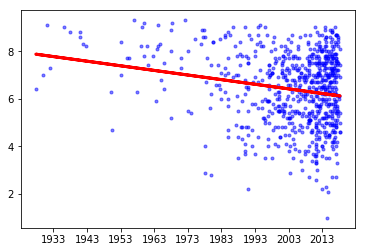

In [10]:
plt.plot(critic_average_test['publication_date'], critic_average_test['critic_average'], 'b.', alpha=0.5)
plt.plot(critic_average_test['publication_date'], critic_average_test['prediction'], 'r-', linewidth=3)
plt.show()

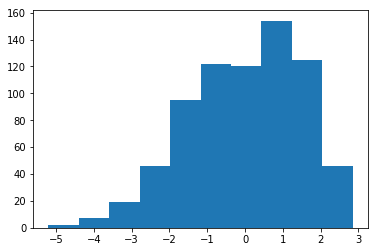

In [11]:
plt.hist(np.subtract(critic_average_test['critic_average'],critic_average_test['prediction']))
plt.show()
#By the central limit theorem, this is close enough to being normal.
#We expect a greater decline on the high end because the average critic rating is higher than the middle rating, 5.

In [12]:
audience_average_test = combined[['publication_date','publication_timestamp','audience_average']].dropna()
fit = stats.linregress(audience_average_test['publication_timestamp'], audience_average_test['audience_average'])
audience_average_test['prediction'] = audience_average_test['publication_timestamp']*fit.slope + fit.intercept
print(fit.pvalue) #p > 0.05, therefore we cannot conclude that the audience ratings are changing.
print(fit.rvalue) #correlation coefficient is low, so it is not very correlated

0.20019655801512012
0.046244255512890686


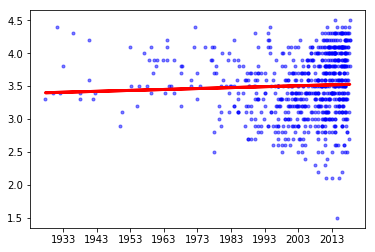

In [13]:
plt.plot(audience_average_test['publication_date'], audience_average_test['audience_average'], 'b.', alpha=0.5)
plt.plot(audience_average_test['publication_date'], audience_average_test['prediction'], 'r-', linewidth=3)
plt.show()

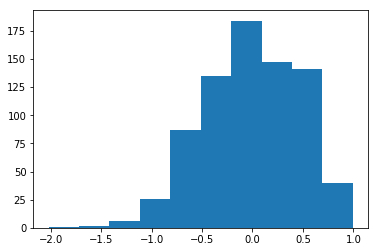

In [14]:
plt.hist(np.subtract(audience_average_test['audience_average'],audience_average_test['prediction']))
plt.show()
#By the central limit theorem, this is close enough to being normal.
#We expect a greater decline on the high end because the average audience rating is higher than the middle rating, 2.5.

# Do average audience ratings change based on its popularity?

In [15]:
audience_ratings_test = combined[['publication_date','publication_timestamp','audience_average','audience_ratings']].dropna()
#Removing movies with n >= 10000000 ratings as they seem like outliers
audience_ratings_test = audience_ratings_test[audience_ratings_test['audience_ratings'] < 10000000]
fit = stats.linregress(audience_ratings_test['audience_ratings'], audience_ratings_test['audience_average'])
audience_ratings_test['prediction'] = audience_ratings_test['audience_ratings']*fit.slope + fit.intercept
print(fit.pvalue) #p < 0.05, therefore we can conclude that higher averages correlate with more popular movies.
print(fit.rvalue) #correlation coefficient is low, so it is not very correlated

0.0003085653249741323
0.130959681001082


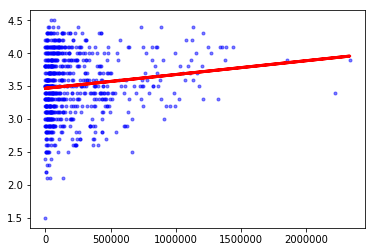

In [16]:
plt.plot(audience_ratings_test['audience_ratings'], audience_ratings_test['audience_average'], 'b.', alpha=0.5)
plt.plot(audience_ratings_test['audience_ratings'], audience_ratings_test['prediction'], 'r-', linewidth=3)
plt.show()

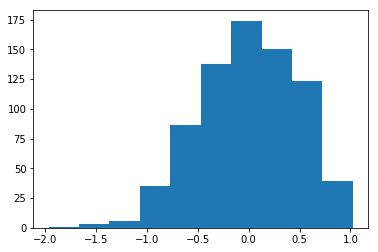

In [17]:
plt.hist(np.subtract(audience_ratings_test['audience_average'],audience_ratings_test['prediction']))
plt.show()
#By the central limit theorem, this is close enough to being normal.
#We expect a greater decline on the high end because the average audience rating is higher than the middle rating, 2.5.

# Does genre have an effect on profitability?

In [18]:
def genre_profit_agg(combined_row):
    for genre_id in combined_row['genre']:
        genre_test.loc[genre_test['wikidata_id'] == genre_id,'total']+=1
        if (combined_row['made_profit'] == 1.0):
            genre_test.loc[genre_test['wikidata_id'] == genre_id,'profit']+=1

In [19]:
genre_test = genres
genre_test['profit'] = 0
genre_test['total'] = 0
combined.apply(genre_profit_agg, axis=1)
genre_test = genre_test[genre_test['total'] > 0]

In [20]:
genre_test['loss'] = genre_test['total'] - genre_test['profit']
genre_test = genre_test[genre_test['profit'] >= 5]
genre_test = genre_test[genre_test['loss'] >= 5]
contingency = genre_test[['profit','loss']]
#contingency = contingency[contingency['profit'] >= 5]
#contingency = contingency[contingency['loss'] >= 5]
chi2, p, dof, expected = stats.chi2_contingency(contingency)
print(p) # p < 0.05, therefore genre effects profitability

C:\Users\Matthew\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0.01956332775267009


In [21]:
genre_test['avg'] = genre_test['profit']/genre_test['total']
genre_test.sort_values(by='avg')
#Science fiction films are the most profitable.

,genre_label,wikidata_id,profit,total,loss,avg
4641,Western,Q172980,6,11,5,0.545455
3502,drama,Q21010853,19,28,9,0.678571
4785,heist film,Q496523,11,16,5,0.687500
3886,family film,Q1361932,20,26,6,0.769231
4438,children's film,Q2143665,29,37,8,0.783784
3713,biographical film,Q645928,41,52,11,0.788462
2948,teen film,Q1146335,27,33,6,0.818182
860,dystopian film,Q20443008,28,34,6,0.823529
4664,action film,Q188473,198,239,41,0.828452
2586,drama film,Q130232,226,272,46,0.830882


# Does country of origin have an effect on profitability?

In [22]:
countries = pd.DataFrame(columns=['country_id', 'made_profit'])
#countries.loc[len(countries)] = ['Q123',1.0]

def add_country_profit(combined_row):
    countries.loc[len(countries)] = [combined_row['country_of_origin'], combined_row['made_profit']]
    return

combined_with_countries = combined[combined['country_of_origin'].notnull()]
combined_with_countries.apply(add_country_profit, axis=1)
countries_groupby = countries.groupby(['country_id'])
countries_avg = countries_groupby.mean()
countries_count = countries_groupby.count()
countries_sum = countries_groupby.sum()
countries_stats = countries_avg
countries_stats['total'] = countries_count
countries_stats['sum'] = countries_sum
countries_stats = countries_stats.reset_index()
countries_stats.columns = ['country_id','percent','total','profit']
countries_stats['loss'] = countries_stats['total'] - countries_stats['profit']
countries_stats = countries_stats[countries_stats['profit'] > 5]
countries_stats = countries_stats[countries_stats['loss'] > 5]

In [23]:
contingency = countries_stats[['profit','loss']]
chi2, p, dof, expected = stats.chi2_contingency(contingency)
print(p) # p < 0.05, therefore country effects profitability

0.003346584394852036


In [24]:
countries_stats #Country Q30, presumably the US, is the best country to make a movie in for profit

,country_id,percent,total,profit,loss
1,Q145,0.838710,62,52.0,10.0
3,Q159,0.677419,31,21.0,10.0
6,Q183,0.625000,16,10.0,6.0
12,Q30,0.860465,602,518.0,84.0


# How well can we predict profitability based on ratings?

In [25]:
predict_profit = combined
predict_profit = predict_profit[predict_profit['critic_average'].notnull()]
predict_profit = predict_profit[predict_profit['audience_average'].notnull()]
predict_profit = predict_profit[predict_profit['critic_percent'].notnull()]
predict_profit = predict_profit[predict_profit['audience_percent'].notnull()]
predict_profit = predict_profit.reset_index(drop=True)
X = predict_profit[['critic_average','audience_average','critic_percent','audience_percent']]
y = predict_profit['made_profit']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y)
model = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=20000)
)
model.fit(X_train, y_train)
print(model.score(X_test, y_test)) #0.8+ score, so pretty well
#model.fit(X, y)

0.8152173913043478


# Can we predict things based on genre? (nope)
I didn't realise that X needs to be floats... gg what a waste of time T_T

In [26]:
#def genre_average_rating_agg(combined_row):
#    for genre_id in combined_row['genre']:
#        genre_test.loc[genre_test['wikidata_id'] == genre_id,'total']+=1
#        genre_test.loc[genre_test['wikidata_id'] == genre_id,'total_aud_avg']+=combined_row['audience_average']
#        genre_test.loc[genre_test['wikidata_id'] == genre_id,'total_cri_avg']+=combined_row['critic_average']
#        if (combined_row['made_profit'] == 1.0):
#            genre_test.loc[genre_test['wikidata_id'] == genre_id,'profit']+=1

In [27]:
#combined_no_nan_ratings = combined[combined['critic_average'].notnull()]
#combined_no_nan_ratings = combined_no_nan_ratings[combined_no_nan_ratings['audience_average'].notnull()].reset_index(drop=True)
#genre_test = genres
#genre_test['profit'] = 0
#genre_test['total_aud_avg'] = 0
#genre_test['total_cri_avg'] = 0
#genre_test['total'] = 0
#combined.apply(genre_average_rating_agg, axis=1)
#genre_test = genre_test[genre_test['total'] > 0]

In [28]:
#genre_test.loc[:,'aud_avg'] = genre_test['total_aud_avg']/genre_test['total']
#genre_test.loc[:,'cri_avg'] = genre_test['total_cri_avg']/genre_test['total']
#Dont know about the SettingWithCopyWarning, can probably just ignore since it is just a warning

In [29]:
#genre_test = genre_test.reset_index(drop=True)
#X = genre_test.drop(columns=['aud_avg','cri_avg','profit','total','total_aud_avg','total_cri_avg','genre_label'])
#y = genre_test['aud_avg']

#X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y)
#model = make_pipeline(
#    StandardScaler(),
#    SVC(kernel='rbf', C=20000)
#)
#model.fit(X_train, y_train)
#print(model.score(X_test, y_test))
#model.fit(X, y)


In [30]:
#NLP
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [31]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(test3["omdb_plot"])

In [32]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [33]:
from sklearn.naive_bayes import MultinomialNB
y=test3["audience_average"]
y=y.astype('int')
clf = MultinomialNB().fit(X_train_tfidf, y)

In [34]:
docs_new = ['love', 'Fat']
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)
predicted = clf.predict(X_new_tfidf)

In [35]:
for doc, category in zip(docs_new, predicted):
     print('%r => %s' % (doc, test3["omdb_plot"][category])) #not working?

'love' => Lt. John Dunbar is dubbed a hero after he accidentally leads Union troops to a victory during the Civil War. He requests a position on the western frontier, but finds it deserted. He soon finds out he is not alone, but meets a wolf he dubs "Two-socks" and a curious Indian tribe. Dunbar quickly makes friends with the tribe, and discovers a white woman who was raised by the Indians. He gradually earns the respect of these native people, and sheds his white-man's ways.
'Fat' => Lt. John Dunbar is dubbed a hero after he accidentally leads Union troops to a victory during the Civil War. He requests a position on the western frontier, but finds it deserted. He soon finds out he is not alone, but meets a wolf he dubs "Two-socks" and a curious Indian tribe. Dunbar quickly makes friends with the tribe, and discovers a white woman who was raised by the Indians. He gradually earns the respect of these native people, and sheds his white-man's ways.
